In [1]:
import platform
import torch

print("Python version")
!python --version

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
Python 3.11.10

OS information
Linux-5.4.0-193-generic-x86_64-with-glibc2.31

Is GPU available?
True

GPU information
Wed Oct  9 15:44:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:01:00.0 Off |                  Off |
| 30%   34C    P8              16W / 230W |   5835MiB / 24564MiB |      0%      Default |
|                        

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
import time
import os

In [3]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                            train=True,
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                           train=False,
                           transform=transform_test)

STEP 1: LOADING DATASET


100.0%


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10/


In [4]:
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [5]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [6]:
print("The number of classes : ", len(set([labels for _, labels in reduced_train_dataset])))

The number of classes :  3


In [7]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

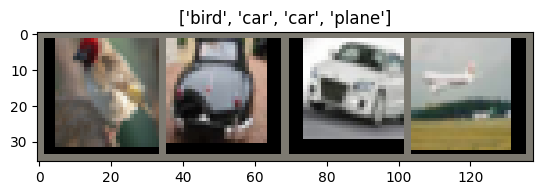

In [13]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=4,
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1ZYDfpVBFBvQnVezVcJqRxwh09rUVmxwD" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1JNEea1G-5yOKVLmSCkiYAEJ0HXOys0CR" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="https://docs.google.com/uc?export=download&id=1vY0ys5KAZmMlOKk8Dcv7eAV8pZ9cawzJ" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br>
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br>
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
>

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset

In [14]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')

cfg = [3, 4, 6, 3]

class ResNet_block(nn.Module):
    def __init__(self, in_c, intra_c, out_c, down_sample=False):
        super(ResNet_block, self).__init__()
        self.expand = in_c != out_c
        self.down_sample = down_sample

        # 1x1 conv
        self.conv1 = nn.Conv2d(in_c, intra_c, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(intra_c)
        
        # 3x3 conv
        self.conv2 = nn.Conv2d(intra_c, intra_c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intra_c)
        
        # 1x1 conv
        self.conv3 = nn.Conv2d(intra_c, out_c, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_c)
        
        # Dimension converter
        if self.expand:
            self.convert_id = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_c)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.expand:
            identity = self.convert_id(x)
        
        # Skip connection
        out = F.relu(out + identity)
        
        # Downsample
        if self.down_sample:
            out = F.avg_pool2d(out, kernel_size=2, stride=2)

        return out


class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.init_block = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Bottleneck layers
        self.ResBlock1 = self._make_layers(64, 64, 256, cfg[0], down_sample=False)
        self.ResBlock2 = self._make_layers(256, 128, 512, cfg[1], down_sample=True)
        self.ResBlock3 = self._make_layers(512, 256, 1024, cfg[2], down_sample=True)
        self.ResBlock4 = self._make_layers(1024, 512, 2048, cfg[3], down_sample=True)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, 3)

    def forward(self, x):
        out = self.init_block(x)
        out = self.ResBlock1(out)
        out = self.ResBlock2(out)
        out = self.ResBlock3(out)
        out = self.ResBlock4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

    def _make_layers(self, in_c, intra_c, out_c, num_block, down_sample):
        layers = []
        # blocks without down sampling
        for _ in range(num_block):
            layers.append(ResNet_block(in_c=in_c if _ == 0 else out_c, intra_c=intra_c, out_c=out_c, down_sample=False))
        # last block
        layers.append(ResNet_block(in_c=out_c, intra_c=intra_c, out_c=out_c, down_sample=down_sample))
        return nn.Sequential(*layers)

print('STEP 4: INSTANTIATE MODEL CLASS')

model = ResNet()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  29448259


ResNet(
  (init_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (ResBlock1): Sequential(
    (0): ResNet_block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (convert_id): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
### 2.2 Print test accuracy for every epochs. [1 points]

In [15]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer = optim.Adam(model.parameters(), lr=0.01)

print('STEP 7: TRAIN THE MODEL')
num_epochs = 50

import time

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds == labels).item()
    return correct / len(preds) * 100

def train_model(model, criterion, optimizer, num_epochs):
    start = time.time()
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        running_train_acc = 0.0
        running_test_loss = 0.0
        running_test_acc = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            running_train_acc += accuracy(outputs, labels)
        train_loss.append(running_train_loss / len(train_loader))
        train_acc.append(running_train_acc / len(train_loader))
        
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                running_test_acc += accuracy(outputs, labels)
            test_loss.append(running_test_loss / len(test_loader))
            test_acc.append(running_test_acc / len(test_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Test Loss: {test_loss[-1]:.4f}, Test Acc: {test_acc[-1]:.2f}%")
        
    end = time.time()
    minute = (end-start)//60
    print(f"Training time: {minute}m {end-start-minute*60:.2f}s")
    return train_loss, train_acc, test_loss, test_acc, model

train_loss, train_acc, test_loss, test_acc, model = train_model(model, criterion, optimizer, num_epochs)


STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Epoch 1/50, Train Loss: 1.4706, Train Acc: 49.72%, Test Loss: 5.4615, Test Acc: 35.50%
Epoch 2/50, Train Loss: 0.8495, Train Acc: 64.33%, Test Loss: 0.6854, Test Acc: 71.23%
Epoch 3/50, Train Loss: 0.6010, Train Acc: 76.53%, Test Loss: 0.5506, Test Acc: 77.43%
Epoch 4/50, Train Loss: 0.5334, Train Acc: 78.89%, Test Loss: 0.5475, Test Acc: 78.20%
Epoch 5/50, Train Loss: 0.4892, Train Acc: 81.16%, Test Loss: 0.5222, Test Acc: 80.97%
Epoch 6/50, Train Loss: 0.4455, Train Acc: 82.89%, Test Loss: 0.4211, Test Acc: 83.43%
Epoch 7/50, Train Loss: 0.4102, Train Acc: 83.91%, Test Loss: 0.4493, Test Acc: 83.50%
Epoch 8/50, Train Loss: 0.3831, Train Acc: 85.05%, Test Loss: 0.3927, Test Acc: 84.87%
Epoch 9/50, Train Loss: 0.3548, Train Acc: 86.29%, Test Loss: 0.3825, Test Acc: 85.47%
Epoch 10/50, Train Loss: 0.3303, Train Acc: 87.09%, Test Loss: 0.3630, Test Acc: 86.63%
Epoch 11/50, Train Loss: 0.3025, Train

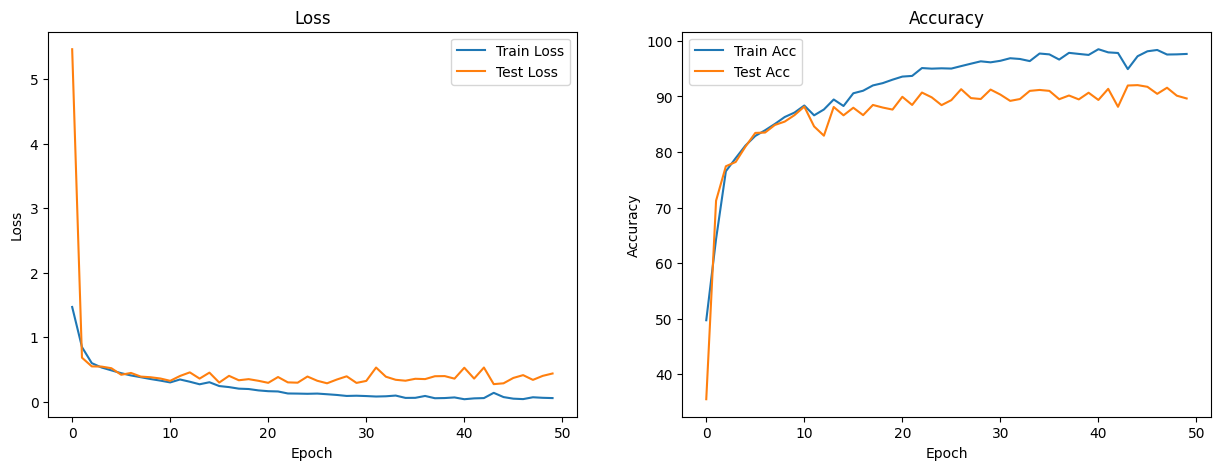

In [16]:
# graph

def display_graph(train_loss, train_acc, test_loss, test_acc):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(train_loss, label='Train Loss')
    ax[0].plot(test_loss, label='Test Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(train_acc, label='Train Acc')
    ax[1].plot(test_acc, label='Test Acc')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()
    
display_graph(train_loss, train_acc, test_loss, test_acc)

In [17]:
print('TEST THE MODEL and SAVE')

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 3000 test images: {} %'.format(100 * correct / total))
    
    # Save the model pt
    torch.save(model.state_dict(), 'LAB_1_ResNet50.pt')

TEST THE MODEL and SAVE
Test Accuracy of the model on the 3000 test images: 89.63333333333334 %


Load PT Model and VISUALIZE THE RESULT


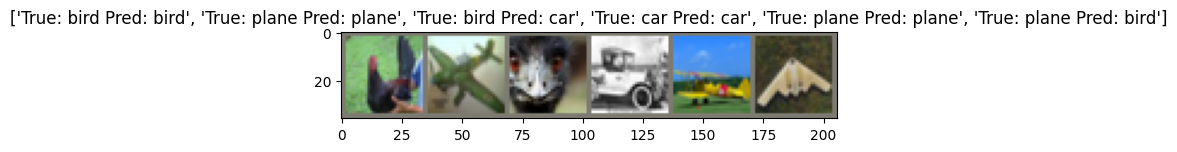

In [18]:
print('Load PT Model and VISUALIZE THE RESULT')

loaded_model = ResNet()
loaded_model.to(device)
loaded_model.load_state_dict(torch.load('LAB_1_ResNet50.pt', map_location=device, weights_only=False))

with torch.no_grad():
    model.eval()
    # Visualize the result of only 4 images
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    
    # Select only the first 4 images and labels
    images = images[5:11]
    labels = labels[5:11]
    
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Make a grid from the batch
    out = torchvision.utils.make_grid(images.cpu())
    
    # Show images with Ground Truth and Predictions
    imshow(out, title=[f'True: {class_names[x]} Pred: {class_names[y]}' for x, y in zip(labels, predicted)])